In [1]:
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder  # , LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
# from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

# Load Data

In [2]:
#https://www.openml.org/d/31
credit_g = fetch_openml('credit-g', version=1)
credit_data = credit_g['data']
credit_data['target'] = credit_g['target']
credit_data.shape

(1000, 21)

In [3]:
## Create Missing Values
credit_data['duration'].iloc[0:46] = np.nan
credit_data['checking_status'].iloc[25:75] = np.nan
credit_data['credit_amount'].iloc[10:54] = 0

/Users/shanekercheval/opt/anaconda3/envs/python-examples/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
hlp.pandas.numeric_summary(credit_data, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
duration,954,46,5.0%,0,0.0%,20.9,12.0,0.6,1.1,1.0,4.0,9.0,12.0,18.0,24.0,36.0,72.0
credit_amount,"1,000",0,0.0%,44,4.0%,"3,132.9","2,853.4",0.9,1.9,4.3,0.0,740.0,"1,287.8","2,224.0","3,873.5","7,119.8","18,424.0"
installment_commitment,"1,000",0,0.0%,0,0.0%,3.0,1.1,0.4,-0.5,-1.2,1.0,1.0,2.0,3.0,4.0,4.0,4.0
residence_since,"1,000",0,0.0%,0,0.0%,2.9,1.1,0.4,-0.3,-1.4,1.0,1.0,2.0,3.0,4.0,4.0,4.0
age,"1,000",0,0.0%,0,0.0%,35.5,11.4,0.3,1.0,0.6,19.0,23.0,27.0,33.0,42.0,52.0,75.0
existing_credits,"1,000",0,0.0%,0,0.0%,1.4,0.6,0.4,1.3,1.6,1.0,1.0,1.0,1.0,2.0,2.0,4.0
num_dependents,"1,000",0,0.0%,0,0.0%,1.2,0.4,0.3,1.9,1.6,1.0,1.0,1.0,1.0,1.0,2.0,2.0


In [6]:
hlp.pandas.non_numeric_summary(credit_data, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
checking_status,950,50,5.0%,no checking,4,0.4%
credit_history,"1,000",0,0.0%,existing paid,5,0.5%
purpose,"1,000",0,0.0%,radio/tv,10,1.0%
savings_status,"1,000",0,0.0%,<100,5,0.5%
employment,"1,000",0,0.0%,1<=X<4,5,0.5%
personal_status,"1,000",0,0.0%,male single,4,0.4%
other_parties,"1,000",0,0.0%,none,3,0.3%
property_magnitude,"1,000",0,0.0%,car,4,0.4%
other_payment_plans,"1,000",0,0.0%,none,3,0.3%
housing,"1,000",0,0.0%,own,3,0.3%


# Training and Test Data

In [7]:
y_full = credit_data['target']
X_full = credit_data.drop(columns='target')

In [8]:
hlp.pandas.value_frequency(series=y_full)

,Frequency,Percent
good,700,0.7
bad,300,0.3


In [9]:
y_full[0:10]

0    good
1     bad
2    good
3    good
4     bad
5    good
6    good
7    good
8    good
9     bad
Name: target, dtype: category
Categories (2, object): ['good', 'bad']

In [10]:
from sklearn.preprocessing import label_binarize
y_full = label_binarize(y_full, classes=['bad', 'good']).flatten()

In [11]:
y_full[0:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [13]:
print(X_train.shape)
print(len(y_train))

print(X_test.shape)
print(len(y_test))

(800, 20)
800
(200, 20)
200


In [14]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([241, 559]))

In [15]:
np.unique(y_train, return_counts=True)[1] / np.sum(np.unique(y_train, return_counts=True)[1])

array([0.30125, 0.69875])

In [16]:
np.unique(y_test, return_counts=True)[1] / np.sum(np.unique(y_test, return_counts=True)[1])

array([0.295, 0.705])

# Transformation Pipeline

In [17]:
from sklearn.preprocessing import OrdinalEncoder
OrdinalEncoder().fit_transform(X_train[['purpose', 'savings_status']])

array([[0., 2.],
       [2., 2.],
       [9., 1.],
       ...,
       [9., 3.],
       [6., 4.],
       [6., 2.]])

In [19]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [22]:
numeric_pipeline = Pipeline([
    #tune whether or not we want to impute or simply remove rows with missing values
    ('impute_chooser', hlp.sklearn_pipeline.TransformerChooser()),
    # this is here so that we can select between MinMax and Scaler
    # if this pipeline is ran in a context outside of tuning, no transformation will take place
    ('scaling_chooser', hlp.sklearn_pipeline.TransformerChooser()),
])

In [23]:
non_numeric_pipeline = Pipeline([
    ('encoder_chooser', hlp.sklearn_pipeline.TransformerChooser()),
])

In [24]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric_pipeline', numeric_pipeline, numeric_columns),
    ('non_numeric_pipeline', non_numeric_pipeline, non_numeric_columns)
])

In [25]:
#pd.DataFrame(temp)

# Model

In [26]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)

In [27]:
full_pipeline = Pipeline([
    ('preparation', transformations_pipeline),
    ('model', random_forest_model)
])

In [28]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'preparation': ColumnTransformer(transformers=[('numeric_pipeline',
                                  Pipeline(steps=[('impute_chooser',
                                                   TransformerChooser()),
                                                  ('scaling_chooser',
                                                   TransformerChooser())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric_pipeline',
                                  Pipeline(steps=[('encoder_chooser',
                                                   TransformerChooser())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                           

# Grid Search

In [31]:
param_grad = [
    {
        'preparation__numeric_pipeline__impute_chooser__base_transformer': [SimpleImputer(strategy='mean')],
        'preparation__numeric_pipeline__scaling_chooser__base_transformer': [MinMaxScaler(), StandardScaler()],
        'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': [OneHotEncoder(),
                                                                                 hlp.sklearn_pipeline.CustomOrdinalEncoder()],
        'model__max_features': [2, 10, 'auto'],
        'model__n_estimators': [50, 100, 500]
    },
]

In [34]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score  # , roc_auc_score
from sklearn.metrics import SCORERS

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# https://stackoverflow.com/questions/60615281/different-result-roc-auc-score-and-plot-roc-curve
scores = {
    # https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/metrics/_scorer.py#L537
    'ROC/AUC':  SCORERS['roc_auc'],
    'F1': make_scorer(f1_score, greater_is_better=True),
    'Pos. Pred. Val': make_scorer(precision_score, greater_is_better=True),
    'True Pos. Rate': make_scorer(recall_score, greater_is_better=True),
}

In [35]:
num_folds = 5
num_repeats = 2

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
grid_search = GridSearchCV(full_pipeline,
                           param_grid=param_grad,
                           cv=RepeatedKFold(n_splits=num_folds,
                                            n_repeats=num_repeats,
                                            random_state=2),
                           scoring=scores,
                           refit='ROC/AUC',
                           #scoring='roc_auc',
                           return_train_score=True
                          )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=2),
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('numeric_pipeline',
                                                                         Pipeline(steps=[('impute_chooser',
                                                                                          TransformerChooser()),
                                                                                         ('scaling_chooser',
                                                                                          TransformerChooser())]),
                                                                         ['duration',
                                                                          'credit_amount',
                                                                          'installment_commitment',
                                                          

## Results

In [58]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.771524602897316
{'model__max_features': 2, 'model__n_estimators': 500, 'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': OneHotEncoder(), 'preparation__numeric_pipeline__impute_chooser__base_transformer': SimpleImputer(), 'preparation__numeric_pipeline__scaling_chooser__base_transformer': MinMaxScaler()}


In [38]:
grid_search_df = hlp.sklearn_eval.cv_results_to_dataframe(
    searcher=grid_search,
    num_folds=num_folds,
    num_repeats=num_repeats,
    return_style=False
)

In [39]:
column_new_names = {'preparation | non_numeric_pipeline | encoder_chooser | base_transformer': 'transformer | encoder',
                    'preparation | numeric_pipeline | impute_chooser | base_transformer': 'transformer | imputer',
                    'preparation | numeric_pipeline | scaling_chooser | base_transformer': 'transformer | scaler'}
grid_search_df.rename(columns=column_new_names, inplace=True)

In [41]:
grid_search_df.head()

,ROC/AUC Mean,ROC/AUC 95CI.LO,ROC/AUC 95CI.HI,ROC/AUC Training Mean,F1 Mean,F1 95CI.LO,F1 95CI.HI,F1 Training Mean,Pos. Pred. Val Mean,Pos. Pred. Val 95CI.LO,...,Pos. Pred. Val Training Mean,True Pos. Rate Mean,True Pos. Rate 95CI.LO,True Pos. Rate 95CI.HI,True Pos. Rate Training Mean,model | max_features,model | n_estimators,transformer | encoder,transformer | imputer,transformer | scaler
8,0.772,0.747,0.796,1.0,0.841,0.826,0.857,1.0,0.749,0.722,...,1.0,0.962,0.951,0.973,1.0,2,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
9,0.771,0.746,0.796,1.0,0.842,0.826,0.857,1.0,0.749,0.722,...,1.0,0.964,0.953,0.974,1.0,2,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
10,0.770,0.745,0.796,1.0,0.836,0.824,0.849,1.0,0.757,0.732,...,1.0,0.936,0.916,0.957,1.0,2,500,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
11,0.770,0.744,0.795,1.0,0.837,0.824,0.849,1.0,0.758,0.734,...,1.0,0.935,0.915,0.956,1.0,2,500,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
32,0.769,0.743,0.794,1.0,0.836,0.824,0.848,1.0,0.770,0.746,...,1.0,0.918,0.890,0.946,1.0,auto,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()


In [46]:
hlp.sklearn_eval.cv_results_to_dataframe(searcher=grid_search,
                                         num_folds=num_folds,
                                         num_repeats=num_repeats,
                                         return_style=True)

ROC/AUC Mean,ROC/AUC 95CI.LO,ROC/AUC 95CI.HI,ROC/AUC Training Mean,F1 Mean,F1 95CI.LO,F1 95CI.HI,F1 Training Mean,Pos. Pred. Val Mean,Pos. Pred. Val 95CI.LO,Pos. Pred. Val 95CI.HI,Pos. Pred. Val Training Mean,True Pos. Rate Mean,True Pos. Rate 95CI.LO,True Pos. Rate 95CI.HI,True Pos. Rate Training Mean,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
0.772,0.747,0.796,1.000,0.841,0.826,0.857,1.000,0.749,0.722,0.775,1.000,0.962,0.951,0.973,1.000,2,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.771,0.746,0.796,1.000,0.842,0.826,0.857,1.000,0.749,0.722,0.775,1.000,0.964,0.953,0.974,1.000,2,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.770,0.745,0.796,1.000,0.836,0.824,0.849,1.000,0.757,0.732,0.782,1.000,0.936,0.916,0.957,1.000,2,500,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.770,0.744,0.795,1.000,0.837,0.824,0.849,1.000,0.758,0.734,0.782,1.000,0.935,0.915,0.956,1.000,2,500,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.769,0.743,0.794,1.000,0.836,0.824,0.848,1.000,0.770,0.746,0.794,1.000,0.918,0.890,0.946,1.000,auto,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.768,0.742,0.794,1.000,0.835,0.822,0.847,1.000,0.769,0.744,0.794,1.000,0.915,0.887,0.944,1.000,auto,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.767,0.736,0.798,1.000,0.838,0.822,0.853,1.000,0.775,0.748,0.801,1.000,0.914,0.891,0.937,1.000,10,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.767,0.737,0.797,1.000,0.837,0.821,0.852,1.000,0.775,0.747,0.802,1.000,0.912,0.892,0.932,1.000,10,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.767,0.748,0.785,1.000,0.834,0.821,0.847,1.000,0.759,0.733,0.785,1.000,0.928,0.911,0.945,1.000,2,100,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.766,0.747,0.784,1.000,0.830,0.817,0.843,1.000,0.757,0.731,0.782,1.000,0.921,0.904,0.938,1.000,2,100,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [47]:
grid_search_df.fillna(0).groupby('transformer | encoder').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
transformer | encoder,
OneHotEncoder(),0.762722
CustomOrdinalEncoder(),0.754611


In [48]:
grid_search_df.fillna(0).groupby('transformer | scaler').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
transformer | scaler,
MinMaxScaler(),0.758778
StandardScaler(),0.758556


In [49]:
grid_search_df.fillna(0).groupby('model | n_estimators').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
model | n_estimators,
500,0.765167
100,0.758500
50,0.752333


In [50]:
grid_search_df.fillna(0).groupby('model | max_features').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
model | max_features,
2,0.761833
auto,0.758500
10,0.755667


# Random Search

In [54]:
from scipy.stats import randint, uniform  # , expon

0.20365929817363626
0.9897769618960433


(array([114., 112.,  95., 102.,  81., 111.,  98.,  88., 100.,  99.]),
 array([0.2036593 , 0.28227106, 0.36088283, 0.4394946 , 0.51810636,
        0.59671813, 0.6753299 , 0.75394166, 0.83255343, 0.9111652 ,
        0.98977696]),
 <BarContainer object of 10 artists>)

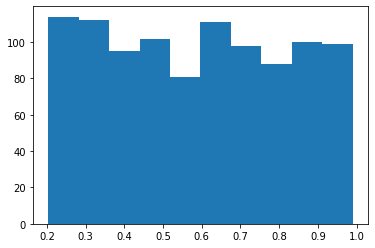

In [52]:
np.random.seed(42)
s = uniform(.2, .79).rvs(size=1000)
print(min(s))
print(max(s))
plt.hist(s)

2
99


(array([111., 105., 104.,  95.,  84., 112.,  98.,  89.,  83., 119.]),
 array([ 2. , 11.7, 21.4, 31.1, 40.8, 50.5, 60.2, 69.9, 79.6, 89.3, 99. ]),
 <BarContainer object of 10 artists>)

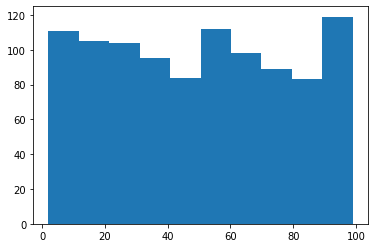

In [53]:
np.random.seed(42)
s = randint(2, 100).rvs(size=1000)
print(min(s))
print(max(s))
plt.hist(s)

In [40]:
s = randint(2, 20)

In [55]:
model_param_dict = [
    {
        'preparation__numeric_pipeline__impute_chooser__base_transformer': [SimpleImputer(strategy='mean')],
        'preparation__numeric_pipeline__scaling_chooser__base_transformer': [MinMaxScaler(), StandardScaler()],
        'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': [
            OneHotEncoder(),
            hlp.sklearn_pipeline.CustomOrdinalEncoder()
        ],
        'model__n_estimators': randint(50, 5000),
        # If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
        'model__max_features':  uniform(.01, .99),
    },
]

In [56]:
num_folds = 5
num_repeats = 2

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
random_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=model_param_dict,
    n_iter=30,
    cv=RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats),
    scoring='roc_auc',
    #return_train_score=True,
    n_jobs=-1,
    #verbose=2,
    random_state=42,
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('preparation',
                                              ColumnTransformer(transformers=[('numeric_pipeline',
                                                                               Pipeline(steps=[('impute_chooser',
                                                                                                TransformerChooser()),
                                                                                               ('scaling_chooser',
                                                                                                TransformerChooser())]),
                                                                               ['duration',
                                                                                'credit_amount',
                                                                                'installment_commitme

## Results

In [59]:
print(random_search.best_score_)
print(random_search.best_params_)

0.761786753072665
{'model__max_features': 0.02548004267378199, 'model__n_estimators': 2618, 'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': CustomOrdinalEncoder(), 'preparation__numeric_pipeline__impute_chooser__base_transformer': SimpleImputer(), 'preparation__numeric_pipeline__scaling_chooser__base_transformer': MinMaxScaler()}


In [61]:
random_search_df = hlp.sklearn_eval.cv_results_to_dataframe(
    searcher=random_search,
    num_folds=num_folds,
    num_repeats=num_repeats,
    return_style=False
)

In [62]:
column_new_names = {'preparation | non_numeric_pipeline | encoder_chooser | base_transformer': 'transformer | encoder',
                    'preparation | numeric_pipeline | impute_chooser | base_transformer': 'transformer | imputer',
                    'preparation | numeric_pipeline | scaling_chooser | base_transformer': 'transformer | scaler'}
random_search_df.rename(columns=column_new_names, inplace=True)

In [63]:
random_search_df.head()

,roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,model | max_features,model | n_estimators,transformer | encoder,transformer | imputer,transformer | scaler
26,0.762,0.739,0.784,0.025480,2618,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
6,0.761,0.739,0.783,0.191570,4605,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
19,0.761,0.739,0.783,0.193006,4848,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
15,0.759,0.736,0.782,0.248615,1528,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
4,0.759,0.735,0.783,0.030379,819,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [64]:
hlp.sklearn_eval.cv_results_to_dataframe(
    searcher=random_search,num_folds=num_folds,
    num_repeats=num_repeats,
    return_style=True
)

roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
0.762,0.739,0.784,0.025,"2,618",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.761,0.739,0.783,0.192,"4,605",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.761,0.739,0.783,0.193,"4,848",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.759,0.736,0.782,0.249,"1,528",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.759,0.735,0.783,0.030,819,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.756,0.735,0.776,0.266,"3,993",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.755,0.734,0.776,0.164,"4,476",OneHotEncoder(),SimpleImputer(),StandardScaler()
0.755,0.733,0.777,0.340,"2,969",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.754,0.732,0.776,0.017,"2,954",OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.752,0.730,0.775,0.207,"1,545",OneHotEncoder(),SimpleImputer(),MinMaxScaler()


In [65]:
random_search_df.fillna(0).groupby('transformer | encoder').agg({'roc_auc Mean': np.mean}).sort_values(by='roc_auc Mean', ascending=False)

,roc_auc Mean
transformer | encoder,
CustomOrdinalEncoder(),0.750437
OneHotEncoder(),0.744214


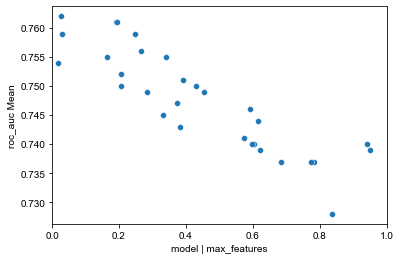

In [66]:
import matplotlib.pyplot as plt
plt.xlim(0, 1)
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.scatterplot(data=random_search_df, x="model | max_features", y="roc_auc Mean")
plt.show()

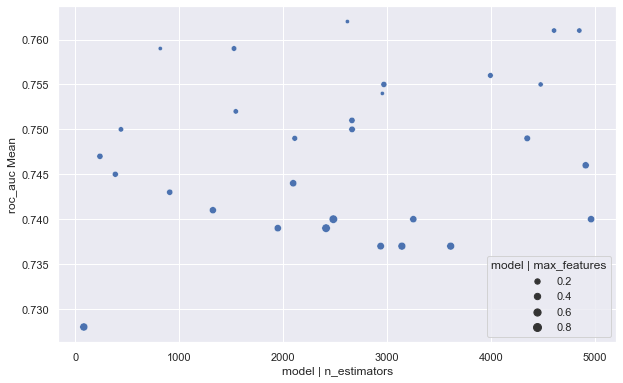

In [67]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.scatterplot(data=random_search_df,
                x="model | n_estimators",
                y="roc_auc Mean",
                size='model | max_features')
plt.show()

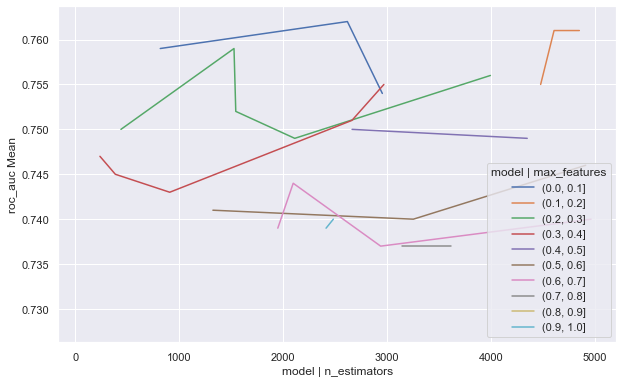

In [68]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.lineplot(data=random_search_df,
                x="model | n_estimators",
                y="roc_auc Mean",
                hue=pd.cut(random_search_df['model | max_features'], bins=np.linspace(0,1,11)))
plt.show()

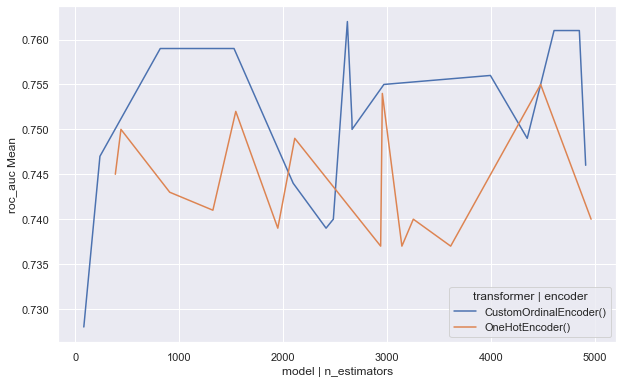

In [69]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.lineplot(data=random_search_df,
                x="model | n_estimators",
                y="roc_auc Mean",
             hue='transformer | encoder')
plt.show()

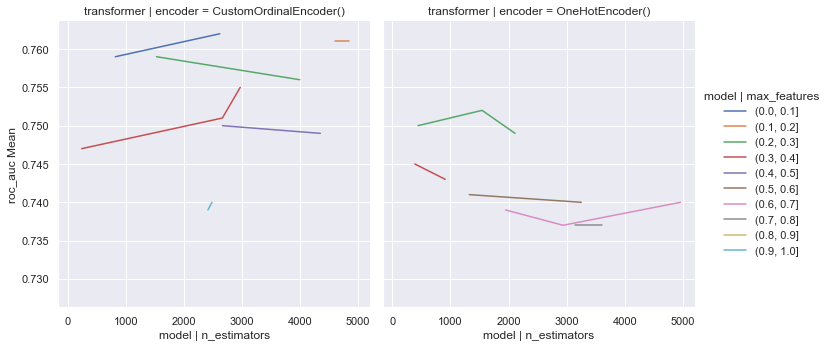

In [70]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.relplot(data=random_search_df,
            kind='line',
            x="model | n_estimators",
            y="roc_auc Mean",
            hue=pd.cut(random_search_df['model | max_features'], bins=np.linspace(0,1,11)),
            col='transformer | encoder')
plt.show()

# skopt.BayesSearchCV

In [71]:
# pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Final Model

In [54]:
best_model = grid_search.best_estimator_

In [55]:
best_model.classes_

array([0, 1])

## Training Set Evaluation

Understand the nature/degree of model overfitting by comparing to `Test Set Evaluation`

In [56]:
predicted_scores = best_model.predict_proba(X_train)[:, 1]

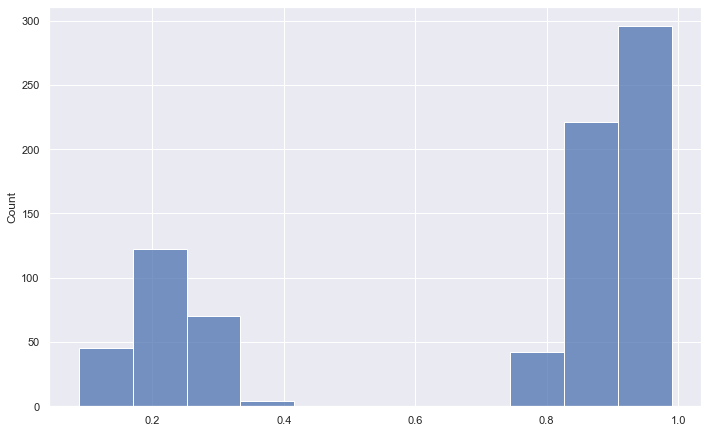

In [57]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [58]:
evaluator = hlp.sklearn.TwoClassEvaluator(
    actual_values=y_train,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

In [59]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,1.000,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 559 ""Good"" labels were correctly identified out of 559 instances; a.k.a Sensitivity/Recall"
True Negative Rate,1.000,"100.0% of negative instances were correctly identified.; i.e. 241 ""Bad"" labels were correctly identified out of 241 instances"
False Positive Rate,0.000,"0.0% of negative instances were incorrectly identified as positive; i.e. 0 ""Bad"" labels were incorrectly identified as ""Good"", out of 241 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 559 instances"
Positive Predictive Value,1.000,"When the model claims an instance is positive, it is correct 100.0% of the time; i.e. out of the 559 times the model predicted ""Good"", it was correct 559 times; a.k.a precision"
Negative Predictive Value,1.000,"When the model claims an instance is negative, it is correct 100.0% of the time; i.e. out of the 241 times the model predicted ""Bad"", it was correct 241 times"
F1 Score,1.000,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,1.000,100.0% of instances were correctly identified
Error Rate,0.000,0.0% of instances were incorrectly identified


## Test Set Evaluation

In [60]:
predicted_scores = best_model.predict_proba(X_test)[:, 1]

In [61]:
predicted_scores

array([0.594, 0.576, 0.422, 0.64 , 0.914, 0.572, 0.884, 0.588, 0.842,
       0.842, 0.82 , 0.546, 0.798, 0.39 , 0.39 , 0.626, 0.798, 0.852,
       0.564, 0.708, 0.752, 0.578, 0.932, 0.972, 0.966, 0.6  , 0.548,
       0.548, 0.728, 0.794, 0.672, 0.708, 0.552, 0.8  , 0.822, 0.7  ,
       0.46 , 0.698, 0.86 , 0.554, 0.636, 0.846, 0.63 , 0.846, 0.9  ,
       0.704, 0.49 , 0.644, 0.656, 0.77 , 0.494, 0.88 , 0.724, 0.594,
       0.786, 0.76 , 0.922, 0.462, 0.486, 0.822, 0.752, 0.558, 0.652,
       0.916, 0.604, 0.712, 0.856, 0.638, 0.626, 0.81 , 0.602, 0.9  ,
       0.756, 0.692, 0.69 , 0.574, 0.704, 0.82 , 0.75 , 0.568, 0.804,
       0.772, 0.942, 0.752, 0.838, 0.514, 0.442, 0.434, 0.826, 0.864,
       0.58 , 0.89 , 0.246, 0.5  , 0.938, 0.802, 0.822, 0.686, 0.452,
       0.62 , 0.958, 0.692, 0.758, 0.924, 0.772, 0.694, 0.61 , 0.566,
       0.732, 0.524, 0.43 , 0.776, 0.706, 0.832, 0.742, 0.758, 0.62 ,
       0.818, 0.838, 0.646, 0.612, 0.56 , 0.764, 0.808, 0.594, 0.786,
       0.528, 0.79 ,

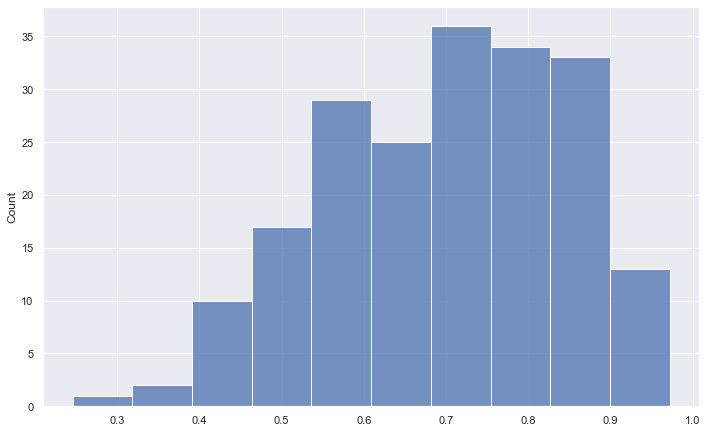

In [62]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [63]:
evaluator = hlp.sklearn.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

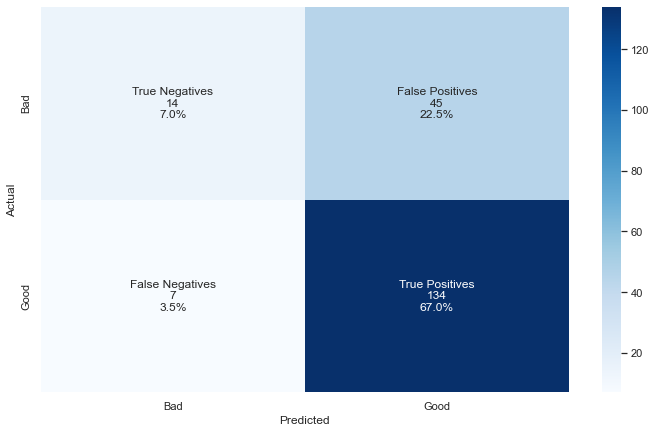

In [64]:
evaluator.plot_confusion_matrix()

In [65]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.808,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,0.950,"95.0% of positive instances were correctly identified.; i.e. 134 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.237,"23.7% of negative instances were correctly identified.; i.e. 14 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,0.763,"76.3% of negative instances were incorrectly identified as positive; i.e. 45 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.050,"5.0% of positive instances were incorrectly identified as negative; i.e. 7 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.749,"When the model claims an instance is positive, it is correct 74.9% of the time; i.e. out of the 179 times the model predicted ""Good"", it was correct 134 times; a.k.a precision"
Negative Predictive Value,0.667,"When the model claims an instance is negative, it is correct 66.7% of the time; i.e. out of the 21 times the model predicted ""Bad"", it was correct 14 times"
F1 Score,0.838,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.740,74.0% of instances were correctly identified
Error Rate,0.260,26.0% of instances were incorrectly identified


Compare results against scores if we predicted all `Good`

In [66]:
dummy_predicted_scores = np.array([0.99] * len(predicted_scores))

In [67]:
dummy_eval = hlp.sklearn.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=dummy_predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)
dummy_eval.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.500,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 141 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.000,"0.0% of negative instances were correctly identified.; i.e. 0 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,1.000,"100.0% of negative instances were incorrectly identified as positive; i.e. 59 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.705,"When the model claims an instance is positive, it is correct 70.5% of the time; i.e. out of the 200 times the model predicted ""Good"", it was correct 141 times; a.k.a precision"
Negative Predictive Value,0.000,"When the model claims an instance is negative, it is correct 0.0% of the time; i.e. out of the 0 times the model predicted ""Bad"", it was correct 0 times"
F1 Score,0.827,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.705,70.5% of instances were correctly identified
Error Rate,0.295,29.5% of instances were incorrectly identified


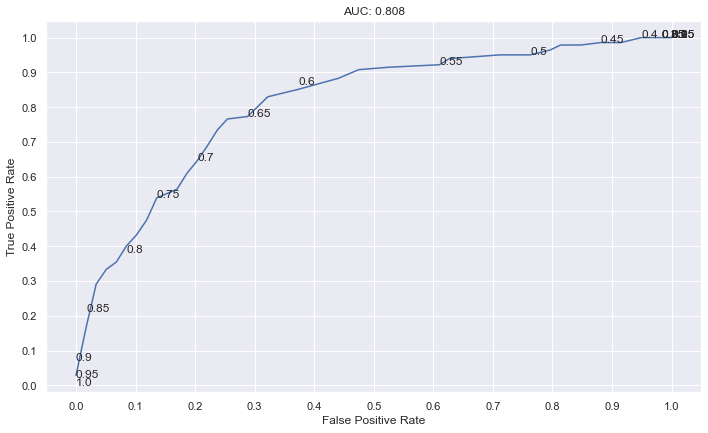

In [68]:
evaluator.plot_auc_curve()
plt.grid()

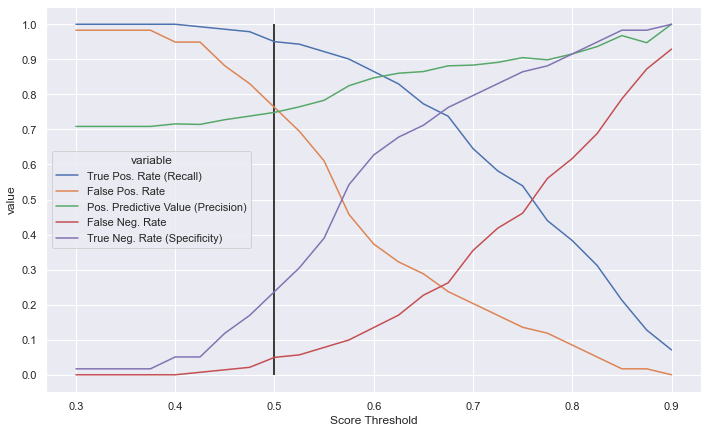

In [69]:
evaluator.plot_threshold_curves()
plt.grid()

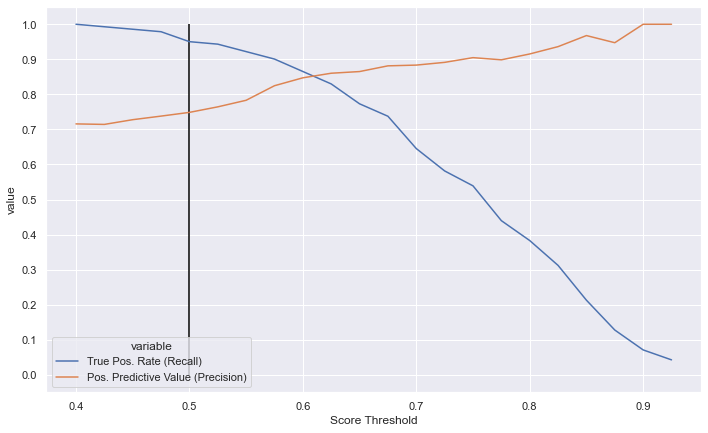

In [87]:
evaluator.plot_precision_recall_tradeoff(score_threshold_range=(0.4, 0.95))
plt.grid()

In [71]:
evaluator.calculate_lift_gain(return_style=True, include_all_info=True)

,# of Obs.,# of Pos. Events,Cumul. Pos. Events,Gain,Lift
Percentile,,,,,
5,10,10,10,0.07,1.42
10,9,8,18,0.13,1.28
15,10,10,28,0.20,1.32
20,9,8,36,0.26,1.28
25,12,11,47,0.33,1.33
30,10,8,55,0.39,1.30
35,9,7,62,0.44,1.26
40,11,10,72,0.51,1.28
45,10,8,80,0.57,1.26


## Feature Importance

todo: how to get features names out of final_estimator?

# Final Model

In [72]:
grid_search.best_params_

{'model__max_features': 2,
 'model__n_estimators': 500,
 'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': OneHotEncoder(),
 'preparation__numeric_pipeline__impute_chooser__base_transformer': SimpleImputer(),
 'preparation__numeric_pipeline__scaling_chooser__base_transformer': MinMaxScaler()}

In [73]:
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer()),
    ('scale', MinMaxScaler()),
])

In [74]:
non_numeric_pipeline = Pipeline([
    ('encoder', OneHotEncoder()),
])

In [75]:
transformations_pipeline = ColumnTransformer([
    ('numeric_pipeline', numeric_pipeline, numeric_columns),
    ('non_numeric_pipeline', non_numeric_pipeline, non_numeric_columns)
])

In [76]:
random_forest_model = RandomForestClassifier(random_state=42, max_features=10, n_estimators=500)

In [77]:
full_pipeline = Pipeline([
    ('preparation', transformations_pipeline),
    ('model', random_forest_model)
])

In [78]:
full_pipeline.fit(X=X_full, y=y_full)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['duration', 'credit_amount',
                                                   'installment_commitment',
                                                   'residence_since', 'age',
                                                   'existing_credits',
                                                   'num_dependents']),
                                                 ('non_numeric_pipeline',
                                                  Pipeline(steps=[('encoder',
                                              

In [79]:
final_model = full_pipeline.named_steps['model']
final_model

RandomForestClassifier(max_features=10, n_estimators=500, random_state=42)

https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer

```
clf.named_steps['preparation'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)
```

In [80]:
new_non_numeric_columns = full_pipeline.named_steps['preparation'].transformers_[1][1].named_steps['encoder'].get_feature_names()
new_non_numeric_columns = list(new_non_numeric_columns)

In [81]:
len(new_non_numeric_columns)

55

In [82]:
len(final_model.feature_importances_)

62

In [83]:
final_column_names = numeric_columns + new_non_numeric_columns

In [84]:
pd.DataFrame({
    'importance (final)': final_model.feature_importances_,
    'importance (cross val)': grid_search.best_estimator_._final_estimator.feature_importances_
    
}, index=final_column_names).\
sort_values(by='importance (final)', ascending=False).\
style.bar(color=hlp.color.GRAY, vmin=0)

,importance (final),importance (cross val)
credit_amount,0.104054,0.081767
age,0.084570,0.072054
duration,0.074995,0.063923
x0_no checking,0.047417,0.033809
x0_<0,0.040988,0.033009
installment_commitment,0.034824,0.038051
residence_since,0.032843,0.037222
x1_critical/other existing credit,0.022264,0.020246
x3_<100,0.020792,0.020250
x2_new car,0.018736,0.018526


# TODO

- get feature importance for model that has various transformations (would have to build pipeline manually based on selected transformers since transformers are being tuned via grid-search)
    - https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
    - https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
   
```
grid_search.best_estimator_._final_estimator.feature_importances_
grid_search.best_estimator_._final_estimator.feature_importances_.shape
```

right now we can get importances but can't get feature names since it is being

In [85]:
#grid_search.best_estimator_.named_steps['preparation'].transformers[1][1].named_steps['encoder_chooser'].base_transformer.get_feature_names()

In [86]:
grid_search.best_estimator_._final_estimator.feature_importances_

array([0.06392319, 0.08176671, 0.0380507 , 0.03722161, 0.07205391,
       0.02128217, 0.01135315, 0.01975279, 0.03300944, 0.00656691,
       0.03380932, 0.00601217, 0.00968149, 0.02024632, 0.00926076,
       0.01689088, 0.01231891, 0.01122847, 0.0028823 , 0.00874858,
       0.01408273, 0.01852644, 0.00232178, 0.01794846, 0.00393875,
       0.0012857 , 0.0097917 , 0.00945918, 0.00701141, 0.0202496 ,
       0.0060604 , 0.01293276, 0.01671606, 0.01361385, 0.01446542,
       0.01615652, 0.00922622, 0.01661636, 0.00602843, 0.00878087,
       0.01772468, 0.00559852, 0.00596786, 0.00940453, 0.01641875,
       0.01420544, 0.01289265, 0.01627603, 0.01343604, 0.01682256,
       0.00647033, 0.00979669, 0.01880648, 0.01291542, 0.01210869,
       0.01706706, 0.00274172, 0.0117306 , 0.01620724, 0.0158297 ,
       0.00347457, 0.00283206])

- future importance
    - https://www.kaggle.com/general/175075
        - LOFO (Leave one feature out) for feature importance.
    - https://explained.ai/rf-importance/